# Reflection spectra to color analysis

This notebook generates a colormap showing the RGB colors that the camera will see according to a given set of CMFs for the reflection spectra of thin films.

## Define spectra generation and RGB computing functions

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import Parallel, delayed
from tqdm import tqdm

# === Readable font size in plots == #

# plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams.update({"font.size": 16})
# plt.rcParams['ps.fonttype'] = 42
plt.rcParams["pdf.fonttype"] = 42
from tmm.tmm_core import coh_tmm

In [21]:
def get_ref_spectra_dlst_nlst(wavs, dlst, nlst):
    """Compute the reflection spectra for series of thin films of constant refractive
    index and thickness. Upper layer first, substrate last.

    Inputs
        wavs [array] - Vector of wavelengths in nm
        dlst [list] - list of film thicknesses [nm]
        nlst [list] - list of film refractive indeces (avg over wavs)
    Output
        coh_tmm reflection [array] - Reflection spectra"""

    reflection = np.empty(wavs.shape)  # Allocate reflection vector
    dlst = [np.inf] + dlst + [np.inf]  # Add empty space before and after layers
    nlst = [1] + nlst + [1]  # Add refractive indeces of empty space

    for q, wav in enumerate(wavs):  # Compute reflection for every wavelength
        reflection[q] = coh_tmm("s", nlst, dlst, 0, wav)["R"]
    return reflection


def spec2rgb(spectra, CMFs):
    """Compute RGB values for a simulated thin film reflection spectra.
    Upper layer first, substrate last.

    Inputs
        spectra - Vector of reflection values for every wavelenght of the CMFs
        CMFs - Matrix containing color matching functions in each column
    Output
        coh_tmm reflection [array] - Reflection spectra"""

    RCMF = CMFS[:, 1]
    GCMF = CMFS[:, 2]
    BCMF = CMFS[:, 3]

    return np.array(
        [np.trapz(spectra * RCMF), np.trapz(spectra * GCMF), np.trapz(spectra * BCMF)]
    )


def film2rgb(d, n, CMFs):
    """Combines the two upper functions to compute the RGB triplet corresponding to
    a film of known thickness and refractive index

    Inputs: d,n, Must be lists
    """
    spec = get_ref_spectra_dlst_nlst(lams, [d], [n])
    return spec2rgb(spec, CMFs)

## User inputs

In [41]:
# Set computation limits
dvec = np.arange(300, 800, 1)
nvec = np.arange(1.45, 1.75, 0.0002)

# Path to CMFs
CMFs = r"./Metadata/v5_CCD_CMFs_lu.npy"

print(
    "Number of points to evaluate\nThickness: {}\nRefractive index: {}".format(
        dvec.size, nvec.size
    )
)

Number of points to evaluate
Thickness: 500
Refractive index: 1501


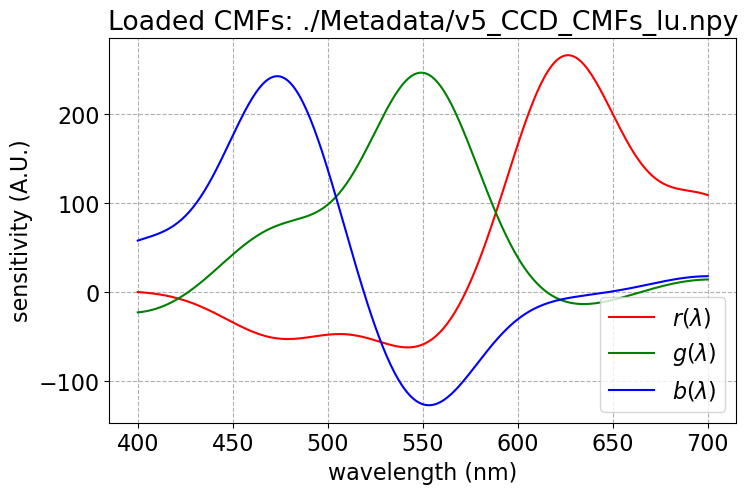

In [42]:
# Save thickness and refractive index vectors
np.save("./Metadata/v6_LUT_dvec_sml.npy", dvec)
np.save("./Metadata/v6_LUT_nvec_sml.npy", nvec)

# Load and plot CMFs
CMFS = np.load(CMFs)
lams = CMFS[:, 0]
RCMF = CMFS[:, 1]
GCMF = CMFS[:, 2]
BCMF = CMFS[:, 3]

plt.figure(figsize=(1.618 * 5, 5))
plt.plot(lams, RCMF, c="red", label="$r(\lambda)$")
plt.plot(lams, GCMF, c="green", label="$g(\lambda)$")
plt.plot(lams, BCMF, c="blue", label="$b(\lambda)$")
plt.xlabel("wavelength (nm)")
plt.ylabel("sensitivity (A.U.)")
plt.title("Loaded CMFs: " + CMFs)
plt.legend()
plt.grid(True, linestyle="--")
plt.savefig("CMFs_LU_v3.pdf", bbox_inches="tight")
plt.show()

In [43]:
# Allocate empty matrix to store RGB values for all n and d combinations
LU_LUT = np.empty((nvec.size, dvec.size, 3))

# Compute RGB values for all combinations and store. Computation is parallelized for speed.
LU_LUT = np.empty((nvec.size, dvec.size, 3))
for i, n in enumerate(tqdm(nvec)):
    # Fill up a complete row of the lookup table at a time.
    LU_LUT[i, :] = Parallel(n_jobs=-1)(delayed(film2rgb)(d, n, CMFS) for d in dvec)

100%|███████████████████████████████████████████████████████████████████████████████| 1501/1501 [14:26<00:00,  1.73it/s]


In [44]:
# dvec, nvec, LU_LUT = np.load('LUT_dvec.npy'), np.load('LUT_nvec.npy'), np.load('RGB_LU_LUT.npy')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_39740/3596769872.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dlabels)
/tmp/ipykernel_39740/3596769872.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(nlabels)


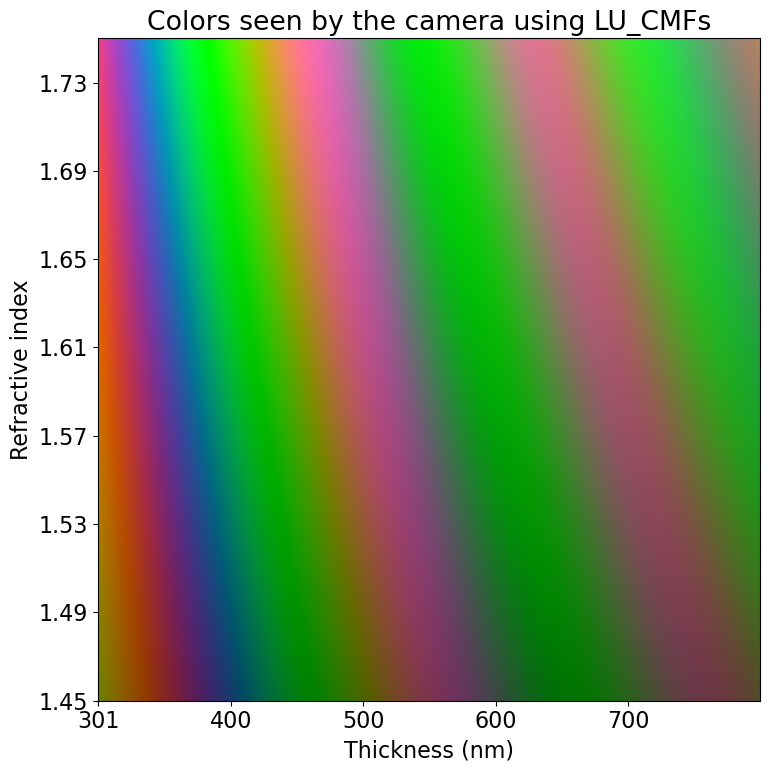

In [45]:
# Convert obtained colors to 0-1 range
LUT_colors = LU_LUT / 2**14

fig, ax = plt.subplots(figsize=(1.618 * 8, 8))
ax.imshow(LUT_colors * 4, origin="lower", aspect=dvec.size / nvec.size)

xticks = ax.get_xticks()
dticks = [int(i) - 1 for i in xticks]

# Fix end values
dticks[1] = 0
dticks[0] = 0
dticks[-1] = 0
dlabels = ["{:3.0f}".format(i + 1) for i in dvec[dticks]]
ax.set_xticklabels(dlabels)
ax.set_xlabel("Thickness (nm)")

yticks = ax.get_yticks()
nticks = [int(i) - 1 for i in yticks]
nticks[1] = 0
nticks[0] = 0
nticks[-1] = 0
nlabels = ["{:.2f}".format(i) for i in nvec[nticks]]
ax.set_yticklabels(nlabels)
ax.set_ylabel("Refractive index")

ax.set_title("Colors seen by the camera using LU_CMFs")
plt.tight_layout()
plt.savefig("./results/LU_colors_editv5.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [46]:
np.save("./Metadata/v6_LU_LUT_sml.npy", LU_LUT)

# LU for thin films on SI

In [3]:
#==============#
Si_disp = np.loadtxt(r"./c-Si_HJY_dispersion.txt", skiprows=4)

def Si_n(wl0):
    """Returns the complex refractive index of crystalline Si at a given wavelenth
    from tabulated data

    Inputs:
        wl0- Wavelenght

    Output:
        n+ik - refractive index value"""
    wl, n, k = Si_disp[:, 0], Si_disp[:, 1], Si_disp[:, 2]
    return np.interp(wl0, wl, n) + 1j * np.interp(wl0, wl, k)
def get_ref_spectra_d_ndisp(wavs, d, disp):
    """Computes the reflection amplitude for 's' polarized light using TMM at a
    multiple wavelengths for single layer of material with constant refractive index on Si

    Inputs:
        wavs [array] - Vector of wavelengths in nm
        d [float] - thickness [nm]
        disp [array] - refractive index values at each wavelength, must match wavs vector
    Output:
        coh_tmm reflection [array] - Amplitude value"""

    reflection = np.zeros(wavs.shape)
    d_list = [np.inf, d, 500000, np.inf]  # Air, layer, Si, Air
    for q, n in enumerate(disp):
        wl0 = wavs[q]
        nk_list = [1, n, Si_n(wl0), 1]
        reflection[q] = coh_tmm("s", nk_list, d_list, 0, wl0)["R"]
    return reflection
def spec2rgb_d_n(d, n):
    """Compute RGB values for a simulated film on Si spectra"""
    spectra = get_ref_spectra_d_ndisp(lams, d, np.ones(lams.shape) * n)
    rgb_pred = np.array(
        [np.trapz(spectra * RCMF), np.trapz(spectra * GCMF), np.trapz(spectra * BCMF)]
    )
    return rgb_pred
#==============#

In [15]:
# d_list = [np.inf, d, 500000, np.inf]

# Set computation limits
dvec = np.arange(20, 900, .5)
nvec = np.arange(1.4, 1.7, 0.0001)

# Path to CMFs
CMFs = r"./Metadata/v5_CCD_CMFs_lu.npy"

print(
    "Number of points to evaluate\nThickness: {}\nRefractive index: {}".format(
        dvec.size, nvec.size
    )
)

Number of points to evaluate
Thickness: 1760
Refractive index: 3001


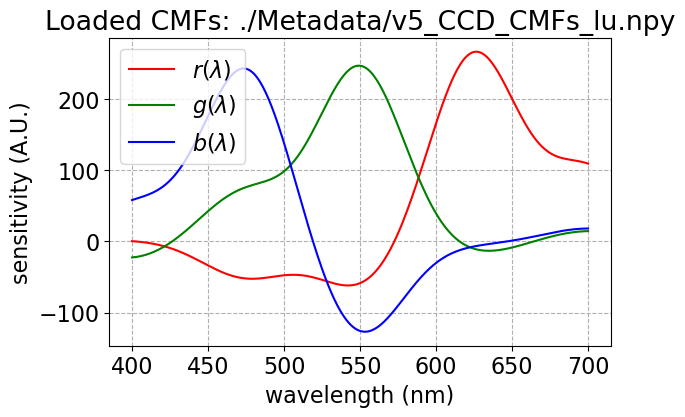

In [16]:
# Save thickness and refractive index vectors
np.save("./Metadata/Si_LUT_dvec_sml.npy", dvec)
np.save("./Metadata/Si_LUT_nvec_sml.npy", nvec)

# Load and plot CMFs
CMFS = np.load(CMFs)
lams = CMFS[:, 0]
RCMF = CMFS[:, 1]
GCMF = CMFS[:, 2]
BCMF = CMFS[:, 3]

plt.figure(figsize=(1.618 * 4, 4))
plt.plot(lams, RCMF, c="red", label="$r(\lambda)$")
plt.plot(lams, GCMF, c="green", label="$g(\lambda)$")
plt.plot(lams, BCMF, c="blue", label="$b(\lambda)$")
plt.xlabel("wavelength (nm)")
plt.ylabel("sensitivity (A.U.)")
plt.title("Loaded CMFs: " + CMFs)
plt.legend()
plt.grid(True, linestyle="--")
plt.savefig("CMFs_LU_v3.pdf", bbox_inches="tight")
plt.show()

In [17]:
# Allocate empty matrix to store RGB values for all n and d combinations
LU_LUT = np.empty((nvec.size, dvec.size, 3))

# Compute RGB values for all combinations and store. Computation is parallelized for speed.
LU_LUT = np.empty((nvec.size, dvec.size, 3))
for i, n in enumerate(tqdm(nvec)):
    # Fill up a complete row of the lookup table at a time.
    LU_LUT[i, :] = Parallel(n_jobs=-1)(
        delayed(spec2rgb_d_n)(d, n) for d in dvec
    )

100%|█████████████████████████████████████████████████████████████████████████████| 3001/3001 [2:17:14<00:00,  2.74s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


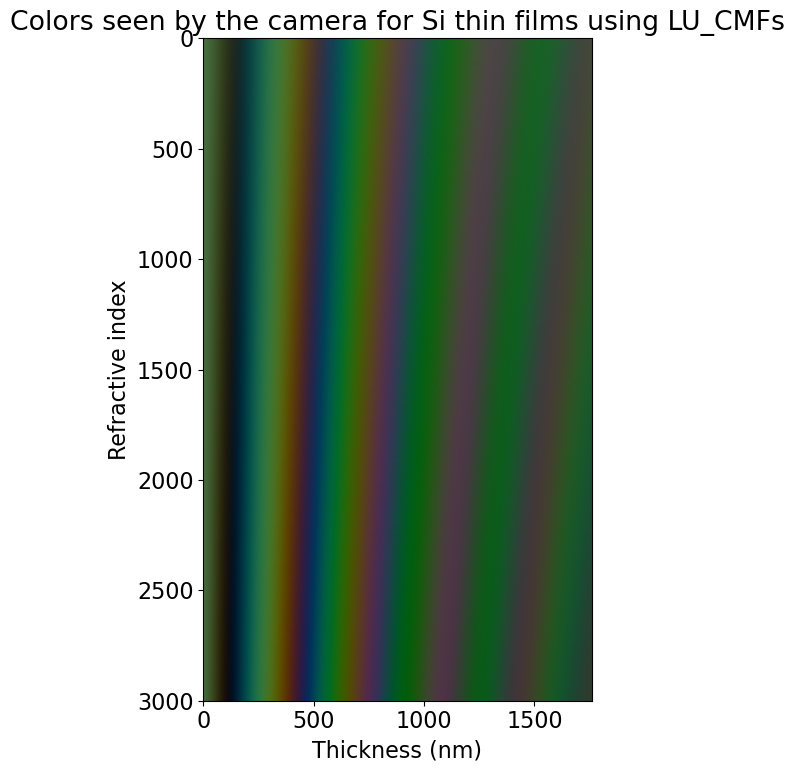

In [18]:
# Convert obtained colors to 0-1 range
LUT_colors = LU_LUT / 2**14

fig, ax = plt.subplots(figsize=(1.618 * 8, 8))
# ax.pcolormesh(dvec[::40], nvec[::40],LUT_colors[::40,::40] * 4)
ax.imshow(LUT_colors)
xticks = ax.get_xticks()
dticks = [int(i) - 1 for i in xticks]

ax.set_xlabel("Thickness (nm)")

ax.set_ylabel("Refractive index")

ax.set_title("Colors seen by the camera for Si thin films using LU_CMFs")
plt.tight_layout()
plt.savefig("./results/SI_LU_colors_editv5.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [19]:
np.save("./Metadata/Si_LU_LUT_until_140-170_sml.npy", LU_LUT)

# LD CMFS

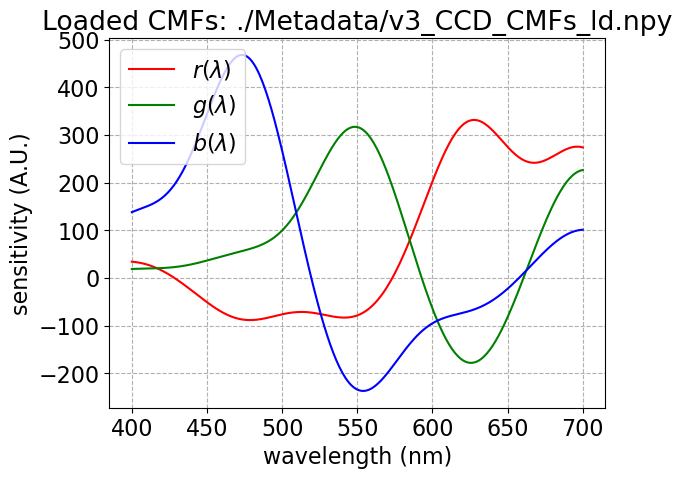

In [6]:
# Load and plot CMFs
CMFs = r"./Metadata/v3_CCD_CMFs_ld.npy"

CMFS = np.load(CMFs)
lams = CMFS[:, 0]
RCMF = CMFS[:, 1]
GCMF = CMFS[:, 2]
BCMF = CMFS[:, 3]

plt.plot(lams, RCMF, c="red", label="$r(\lambda)$")
plt.plot(lams, GCMF, c="green", label="$g(\lambda)$")
plt.plot(lams, BCMF, c="blue", label="$b(\lambda)$")
plt.xlabel("wavelength (nm)")
plt.ylabel("sensitivity (A.U.)")
plt.title("Loaded CMFs: " + CMFs)
plt.legend()
plt.grid(True, linestyle="--")
plt.show()

In [7]:
# Allocate empty matrix to store RGB values for all n and d combinations
LD_LUT = np.empty((nvec.size, dvec.size, 3))

# Compute RGB values for all combinations and store. Computation is parallelized for speed.
LD_LUT = np.empty((nvec.size, dvec.size, 3))
for i, n in enumerate(tqdm(nvec)):
    # Fill up a complete row of the lookup table at a time.
    LD_LUT[i, :] = Parallel(n_jobs=-1)(delayed(film2rgb)(d, n, CMFS) for d in dvec)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2700/2700 [7:29:09<00:00,  9.98s/it]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/tmp/ipykernel_20844/3784068931.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dlabels)
/tmp/ipykernel_20844/3784068931.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(nlabels)


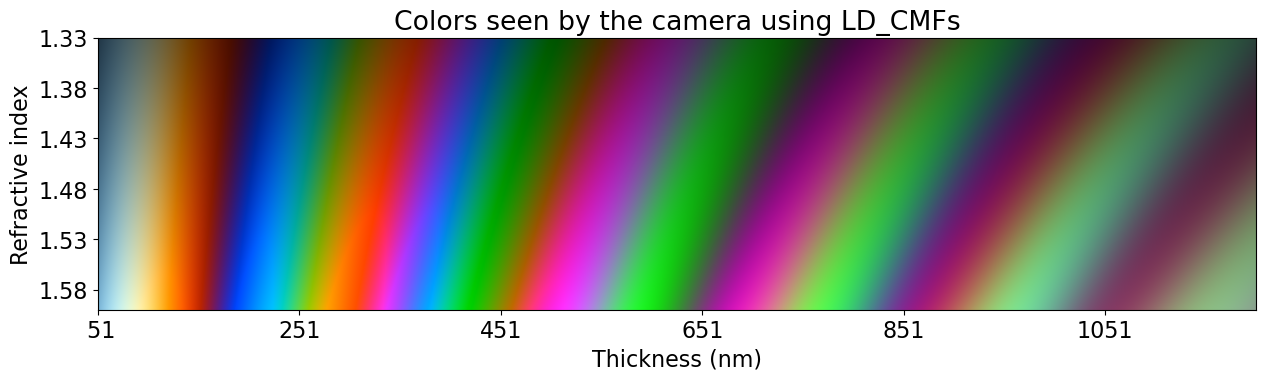

In [8]:
# Convert obtained colors to 0-1 range
LUT_colors = LD_LUT / 2**14

fig, ax = plt.subplots(figsize=(1.618 * 8, 8))
ax.imshow(LUT_colors * 4)

xticks = ax.get_xticks()
dticks = [int(i) - 1 for i in xticks]

# Fix end values
dticks[1] = 0
dticks[0] = 0
dticks[-1] = 0
dlabels = ["{:3.0f}".format(i) for i in dvec[dticks] + 1]
ax.set_xticklabels(dlabels)
ax.set_xlabel("Thickness (nm)")

yticks = ax.get_yticks()
nticks = [int(i) - 1 for i in yticks]
nticks[1] = 0
nticks[0] = 0
nticks[-1] = 0
nlabels = ["{:.2f}".format(i) for i in nvec[nticks]]
ax.set_yticklabels(nlabels)
ax.set_ylabel("Refractive index")

ax.set_title("Colors seen by the camera using LD_CMFs")
plt.tight_layout()
plt.show()

In [9]:
np.save("v5_LUT_LD_until_160.npy", LD_LUT)

In [ ]:
tmp = np.abs(LD_LUT - LD_LUT[400, 400])
gray = tmp.sum(axis=2)
print(gray.shape)

print(np.argmin(gray, keepdims=True))
# plt.pcolor(np.log(gray+1))